In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
import os

from bson import ObjectId
from datetime import datetime
from pymongo import MongoClient, ASCENDING, DESCENDING

In [ ]:
os.environ["AWS_DEFAULT_REGION"] = "us-east-1"
os.environ["AWS_ACCESS_KEY_ID"] = ""
os.environ["AWS_SECRET_ACCESS_KEY"] = ""
os.environ["MONGO_USER"]= "mongo_admin"
os.environ["MONGO_PASS"]= ""
os.environ["MONGO_HOST"]= "localhost:27018"
os.environ["MONGO_DATABASE"]= "simple_live"

In [32]:
with open("records.csv") as f:
    records = pd.read_csv(f)
    
def create_qualification_type(mturk, name):
    paginator = mturk.get_paginator('list_qualification_types')
    found = False
    found_id = None

    for quals in paginator.paginate(MustBeRequestable=False, MustBeOwnedByCaller=True):
        for obj in quals["QualificationTypes"]:

            if obj["Name"] == name:
                found = True
                found_id = obj["QualificationTypeId"]
                break

    if not found:
        response = mturk.create_qualification_type(Name=name,
                                    Keywords="claim,wikipedia,evidence,search,true,false,finding,natural,question,ai",
                                    Description="Pass a qualification test to show you can find information from a Wikipedia page that supports or refutes a claim.",
                                    QualificationTypeStatus="Active",
                                    RetryDelayInSeconds=60*60*24)
        return response["QualificationType"]["QualificationTypeId"]

    return found_id


def qualify_worker(client, worker_id, qual, notify=True):
    client.associate_qualification_with_worker(QualificationTypeId=qual, WorkerId=worker_id, SendNotification=notify, IntegerValue=1)

def disqualify_worker(client, worker_id, qual, reason):
    client.disassociate_qualification_from_worker(QualificationTypeId=qual,
                                                  WorkerId=worker_id,
                                                  Reason=reason)
def freeze_worker(worker_objid):
    db.workers.update({"_id": ObjectId(worker_objid)},
                            {"$set": {"freeze_date": datetime.now()}})

def act_worker(worker_objid):
    db.workers.update({"_id": ObjectId(worker_objid)},
                            {"$set": {"act_date": datetime.now()}})

def unfreeze_worker(worker_id):
    db.workers.update({"_id": ObjectId(worker_id)},
                            {"$set": {"unfreeze_date": datetime.now()}})
        
def create_or_get_worker(workerId):
    worker = db.workers.find_one({"worker_id": workerId})
    if worker is None:
        worker_id = db.workers.insert({
            "created_date": datetime.now(),
            "status": "active",
            "worker_id": workerId,
        })
        worker = db.workers.find_one({"_id": workerId})
    return worker



In [4]:

client = MongoClient('mongodb://%s:%s@%s' % (os.getenv("MONGO_USER"), os.getenv("MONGO_PASS"), os.getenv("MONGO_HOST")))
db=client[os.getenv("MONGO_DATABASE")]

In [5]:



endpoint_url = 'https://mturk-requester.us-east-1.amazonaws.com'
mturk = boto3.client(
        'mturk',
        endpoint_url=endpoint_url, )


In [31]:
#mturk.create_worker_block(WorkerId="AAA",Reason="spam worker")
#mturk.create_worker_block(WorkerId="AAA",Reason="spam worker")

update = 0 
claims = [anno["claim"] for anno in tqdm(db.annotations.find({"worker_id":"Blocked Worker ID"}))]
updates = db.tie_breaker_claims.find({"claim":{"$in":claims}})

a = [update["claim"] for update in updates]

remaining = set(claims).difference(a)
for claim in tqdm(remaining):
    db.tie_breaker_claims.insert({
        "claim": claim,
        "remaining": 5,
        "workers":[]
    })
#result = db.tie_breaker_claims.update_many({"claim":{"$in":claims}},{"$inc":{"remaining":1}})

{'ResponseMetadata': {'RequestId': '1184c53f-4dec-408a-aeac-b02a2b938c72',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '1184c53f-4dec-408a-aeac-b02a2b938c72',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'date': 'Tue, 25 Aug 2020 23:14:05 GMT'},
  'RetryAttempts': 0}}

In [10]:
if False:
    mturk.notify_workers(Subject="Wikipedia evidence finding task correction rate",
                         MessageText="Hi, I've been reviewing your HITs for the Wikipedia evidence finding task. I've noticed that there were quite a few instances where I had to make corrections. I think there seems to be a systematic issue where you label evidence sentences from the document as True, but then label the claim as False (you should be getting a pop-up message warning you about this too). Could you please review the guidelines and let me know if there's anything you find unclear as this is a new task and we want to help our turkers do their best on this task.",
                         WorkerIds=["BBBB"]
            )

In [55]:
main_qualification = create_qualification_type(mturk, "Wikipedia Evidence Finding: FULL ANNOTATION - Qualification Granted")
freeze_qualification = create_qualification_type(mturk, "Wikipedia Evidence Finding: Soft Block [Awaiting Review]")

In [36]:
pt = pd.pivot_table(records, columns="keep", index="worker", aggfunc={"keep":len}).fillna(0)

In [49]:
pd.pivot_table(records, columns="keep",  aggfunc={"keep":len})

keep,ACCEPT,AUTO ACCEPT,CORRECTED,NOT REVIEWED,REJECT
keep,12137,220227,400,9186,2291


In [ ]:
#super_qualification = create_qualification_type(mturk, "Wikipedia Evidence Finding: Super Annotators")
#qualify_worker(mturk,"AAAA", super_qualification)


244241
10785
10499


<ipython-input-48-6650ccb70f68>:8: MatplotlibDeprecationWarning: Passing the sharex parameter of subplots() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  fig, (ax1,ax2) = plt.subplots(2,1,False,False,figsize=(10,10))


[  7.  12.  24.  47.  92. 141.]
[ 6. 11. 20. 34. 49. 60.]
[ 13.  18.  26.  39.  69. 104.]


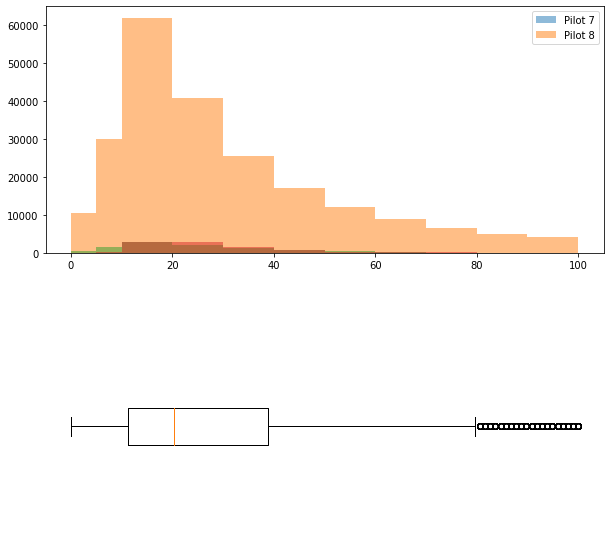

In [48]:
old_times = records[records.variant==3]["annotation_time"]
times = records[records.variant>=6]["annotation_time"]
u_times = records[(records["worker"] == "AAAAA")]["annotation_time"]
s_times = records[(records["worker"] == "BBBBB")]["annotation_time"]
print(len(times))
print(len(u_times))
print(len(s_times))
fig, (ax1,ax2) = plt.subplots(2,1,False,False,figsize=(10,10))
ax1.hist(old_times, bins=[0,5,10,20,30,40,50,60,70,80,90,100], alpha=0.5)
ax1.hist(times, bins=[0,5,10,20,30,40,50,60,70,80,90,100], alpha=0.5)
ax1.hist(u_times, bins=[0,5,10,20,30,40,50,60,70,80,90,100], alpha=0.5)
ax1.hist(s_times, bins=[0,5,10,20,30,40,50,60,70,80,90,100], alpha=0.5)
ax1.legend(["Pilot 7","Pilot 8"])
ax2.axis("off")

ax2.boxplot(times[times<100], vert=False)
print(np.quantile(times,[.10,.25,.50,.75,.90,.95]))
print(np.quantile(u_times,[.10,.25,.50,.75,.90,.95]))
print(np.quantile(s_times,[.10,.25,.50,.75,.90,.95]))

